## 使用ML方法组合估计器
2022-03-21
- 更改目标为平均价差；加入平均收盘价这个特征
2022-04-16
- 完善框架

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
from mytools.AutoTester import AutoTester

from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from sklearn.linear_model import LinearRegression
from tqdm import tqdm

import sys
sys.path.append(r'C:\Users\Administrator\Desktop\Repositories\Low-Frequency-Spread-Estimator\notebook\tools')
from train_tools import *
from get_signal import *
from naive_model import *

In [286]:
import importlib
import train_tools
importlib.reload(train_tools)
from train_tools import *

In [3]:
se = SpreadEstimator()
univ = ~np.isnan(se.data.data_dic['close'])  # 合法的univ

In [4]:
class GateNet(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, dropout: float = 0.7, alpha: float = 0.2):
        super(GateNet, self).__init__()
        self.input_dim = input_dim
        self.output_Dim = output_dim

        self.Dense1 = nn.Linear(input_dim, 16)
        self.Dense2 = nn.Linear(16, 8)
        self.Dense3 = nn.Linear(8, 8)
        self.Dense4 = nn.Linear(8, output_dim)

        self.gate0 = Gate(input_dim)
        self.gate1 = Gate(16)
        self.gate2 = Gate(8)
        self.gate3 = Gate(8)

        self.act = nn.LeakyReLU(alpha)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.act(self.Dense1(self.gate0(self.dropout(x))))
        x = self.act(self.Dense2(self.gate1(self.dropout(x))))
        x = x + self.dropout(self.gate3(self.act(self.Dense3(self.gate2(self.dropout(x))))))
        x = self.Dense4(x)
        return x

### 获得基本的训练数据

In [79]:
signal_spread = get_signal_spread(se)
signal_spread[:,:, :3] *= 10
signal_spread[:,:, 3] = np.log(signal_spread[:,:, 3])
target_spread = get_target(se, 'spread')
signal_rela = get_signal_rela(se)
signal_rela[:,:,:3] *= 100
signal_rela[:,:, 3] = np.log(signal_rela[:,:, 3])
target_rela = get_target(se, 'relative_spread')
target_wrela = get_target(se, 'vol_wtd_rel_bas')

mean corr: -0.4630, positive_corr_ratio: 0.0000, corr_IR: -16.7947
mean corr: 0.7924, positive_corr_ratio: 1.0000, corr_IR: 18.7505
mean corr: -0.3688, positive_corr_ratio: 0.0000, corr_IR: -8.7364
mean corr: -0.3920, positive_corr_ratio: 0.0000, corr_IR: -9.9100
mean corr: -0.2082, positive_corr_ratio: 0.0000, corr_IR: -3.6871
mean corr: 0.0994, positive_corr_ratio: 0.9279, corr_IR: 1.2409
mean corr: -0.2317, positive_corr_ratio: 0.0000, corr_IR: -3.9265
mean corr: -0.3920, positive_corr_ratio: 0.0000, corr_IR: -9.9100


In [189]:
x_train_cs_spread, y_train_cs_spread = get_train_data_cs(signal_spread, target_spread*100, univ)
x_train_cs_rela, y_train_cs_rela = get_train_data_cs(signal_rela, target_rela*100, univ)
x_train_cs_wrela, y_train_cs_wrela = get_train_data_cs(signal_rela, target_wrela*100, univ)

x_train_ts_spread, y_train_ts_spread = get_train_data_ts(signal_spread, target_spread*100, univ)
x_train_ts_rela, y_train_ts_rela = get_train_data_ts(signal_rela, target_rela*100, univ)
x_train_ts_wrela, y_train_ts_wrela = get_train_data_ts(signal_rela, target_wrela*100, univ)

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 1690.55it/s]


In [81]:
y_train_cs_rela[0]

tensor([[0.0717],
        [0.0472],
        [0.1345],
        ...,
        [0.0439],
        [0.1247],
        [0.0347]], device='cuda:0')

### 使用截面相关系数作为损失函数，训练模型

In [82]:
# GateNet cs
device = 'cuda'
n = 4
# model = nn.Linear(n, 1).to(device)

loss_func = ICLoss()

print('spread cs')
gatenet_spread = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(gatenet_spread.parameters(), lr=2e-3, weight_decay=0)
train_cs(x_train_cs_spread, y_train_cs_spread, gatenet_spread, optimizer, loss_func, signal=signal_spread, 
         target=target_spread, univ=univ,
         vs_e=160, os_s=160, epochs=5, batch_size=1)
print()

print('relative spread cs')
gatenet_rela = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(gatenet_rela.parameters(), lr=1e-3, weight_decay=0)
train_cs(x_train_cs_rela, y_train_cs_rela, gatenet_rela, optimizer, loss_func, signal=signal_rela, 
         target=target_rela, univ=univ,
         vs_e=160, os_s=160, epochs=20, batch_size=1,verbose=2)
print()

print('w relative spread cs')
gatenet_wrela = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(gatenet_wrela.parameters(), lr=1e-3, weight_decay=0)
train_cs(x_train_cs_wrela, y_train_cs_wrela, gatenet_wrela, optimizer, loss_func, signal=signal_rela, 
         target=target_wrela, univ=univ,
         vs_e=160, os_s=160, epochs=20, batch_size=1,verbose=2)

spread cs
epoch 1
-0.8282178338569931
vs cs IC: 0.7864
os cs IC: 0.7769
epoch 2
-0.8308666182469718
vs cs IC: 0.7839
os cs IC: 0.7721
epoch 3
-0.8283732865430131
vs cs IC: 0.7869
os cs IC: 0.7764
epoch 4
-0.8355980070331429
vs cs IC: 0.8068
os cs IC: 0.7923
epoch 5
-0.8376229737378373
vs cs IC: 0.8118
os cs IC: 0.7955

relative spread cs
epoch 2
-0.4711224900894478
vs cs IC: 0.5801
os cs IC: 0.5325
epoch 4
-0.7082963038663395
vs cs IC: 0.7028
os cs IC: 0.6818
epoch 6
-0.8053299550150261
vs cs IC: 0.8491
os cs IC: 0.8269
epoch 8
-0.861583125395853
vs cs IC: 0.8801
os cs IC: 0.8705
epoch 10
-0.8851958943195031
vs cs IC: 0.8914
os cs IC: 0.8845
epoch 12
-0.8856101788458277
vs cs IC: 0.8960
os cs IC: 0.8856
epoch 14
-0.8951222525268304
vs cs IC: 0.9010
os cs IC: 0.8879
epoch 16
-0.8973914482554451
vs cs IC: 0.9034
os cs IC: 0.8818
epoch 18
-0.9026984836234421
vs cs IC: 0.9109
os cs IC: 0.8819
epoch 20
-0.9052020282041832
vs cs IC: 0.9148
os cs IC: 0.8800

w relative spread cs
epoch 2
-0.49

In [83]:
# Linear cs
device = 'cuda'
n = 4

loss_func = ICLoss()

print('spread cs')
gatenet_spread = nn.Linear(n, 1).to(device)
optimizer = torch.optim.AdamW(gatenet_spread.parameters(), lr=5e-4, weight_decay=0)
train_cs(x_train_cs_spread, y_train_cs_spread, gatenet_spread, optimizer, loss_func, signal=signal_spread, 
         target=target_spread, univ=univ,
         vs_s=160, os_s=160, epochs=5, batch_size=1)
print()

print('relative spread cs')
gatenet_rela = nn.Linear(n, 1).to(device)
optimizer = torch.optim.AdamW(gatenet_rela.parameters(), lr=5e-3, weight_decay=0)
train_cs(x_train_cs_rela, y_train_cs_rela, gatenet_rela, optimizer, loss_func, signal=signal_rela, 
         target=target_rela, univ=univ,
         vs_s=160, os_s=160, epochs=10, batch_size=1)
print()

print('w relative spread cs')
gatenet_wrela = nn.Linear(n, 1).to(device)
optimizer = torch.optim.AdamW(gatenet_wrela.parameters(), lr=5e-3, weight_decay=0)
train_cs(x_train_cs_wrela, y_train_cs_wrela, gatenet_wrela, optimizer, loss_func, signal=signal_rela, 
         target=target_wrela, univ=univ,
         vs_s=160, os_s=160, epochs=10, batch_size=1)

spread cs
epoch 1
-0.6928252958798711
vs cs IC: 0.7754
os cs IC: 0.7358
epoch 2
-0.8138239119626298
vs cs IC: 0.8169
os cs IC: 0.7769
epoch 3
-0.8321043283124513
vs cs IC: 0.8279
os cs IC: 0.7884
epoch 4
-0.8380216722246967
vs cs IC: 0.8324
os cs IC: 0.7932
epoch 5
-0.8407522794566576
vs cs IC: 0.8348
os cs IC: 0.7957

relative spread cs
epoch 1
0.2079797791256035
vs cs IC: 0.2099
os cs IC: 0.2810
epoch 2
-0.42550556092965797
vs cs IC: 0.3723
os cs IC: 0.4416
epoch 3
-0.5253162447546349
vs cs IC: 0.4444
os cs IC: 0.5065
epoch 4
-0.5828037154479105
vs cs IC: 0.5061
os cs IC: 0.5593
epoch 5
-0.6333525376241715
vs cs IC: 0.5703
os cs IC: 0.6118
epoch 6
-0.6811269599883283
vs cs IC: 0.6362
os cs IC: 0.6638
epoch 7
-0.7217424541223244
vs cs IC: 0.6936
os cs IC: 0.7083
epoch 8
-0.7490994060625795
vs cs IC: 0.7311
os cs IC: 0.7381
epoch 9
-0.7611170274312379
vs cs IC: 0.7459
os cs IC: 0.7514
epoch 10
-0.7607899083465827
vs cs IC: 0.7440
os cs IC: 0.7523

w relative spread cs
epoch 1
0.2552840

In [84]:
# GateNet时序
print('spread ts')
gatenet_spread_ts = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(gatenet_spread_ts.parameters(), lr=1e-3, weight_decay=0)
train_ts(x_train_ts_spread, y_train_ts_spread, gatenet_spread_ts, optimizer, loss_func, signal=signal_spread, 
         target=target_spread, univ=univ,
         vs_s=800, os_s=1400, epochs=5, batch_size=5)
print()

print('relative spread ts')
gatenet_rela_ts = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(gatenet_rela_ts.parameters(), lr=5e-4, weight_decay=0)
train_ts(x_train_ts_rela, y_train_ts_rela, gatenet_rela_ts, optimizer, loss_func, signal=signal_rela, 
         target=target_rela, univ=univ,
         vs_s=800, os_s=1400, epochs=10, batch_size=3)
print()

print('w relative spread ts')
gatenet_wrela_ts = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(gatenet_wrela_ts.parameters(), lr=5e-4, weight_decay=0)
train_ts(x_train_ts_wrela, y_train_ts_wrela, gatenet_wrela_ts, optimizer, loss_func, signal=signal_rela, 
         target=target_wrela, univ=univ,
         vs_s=800, os_s=1400, epochs=10, batch_size=3)

spread ts
epoch 1
vs ts IC: 0.4507
os ts IC: 0.5854
epoch 2
vs ts IC: 0.4989
os ts IC: 0.6403
epoch 3
vs ts IC: 0.5178
os ts IC: 0.6550
epoch 4
vs ts IC: 0.5245
os ts IC: 0.6602
epoch 5
vs ts IC: 0.5291
os ts IC: 0.6652

relative spread ts
epoch 1
vs ts IC: 0.1172
os ts IC: 0.1302
epoch 2
vs ts IC: 0.2053
os ts IC: 0.2394
epoch 3
vs ts IC: 0.3733
os ts IC: 0.3263
epoch 4
vs ts IC: 0.4226
os ts IC: 0.4080
epoch 5
vs ts IC: 0.5167
os ts IC: 0.4700
epoch 6
vs ts IC: 0.5154
os ts IC: 0.4611
epoch 7
vs ts IC: 0.5514
os ts IC: 0.5110
epoch 8
vs ts IC: 0.5856
os ts IC: 0.5405
epoch 9
vs ts IC: 0.5853
os ts IC: 0.5585
epoch 10
vs ts IC: 0.6318
os ts IC: 0.5598

w relative spread ts
epoch 1
vs ts IC: 0.1106
os ts IC: 0.1182
epoch 2
vs ts IC: 0.1816
os ts IC: 0.1937
epoch 3
vs ts IC: 0.3472
os ts IC: 0.3429
epoch 4
vs ts IC: 0.3454
os ts IC: 0.3805
epoch 5
vs ts IC: 0.5017
os ts IC: 0.5002
epoch 6
vs ts IC: 0.5237
os ts IC: 0.4938
epoch 7
vs ts IC: 0.5621
os ts IC: 0.5403
epoch 8
vs ts IC: 0.603

In [85]:
# Linear时序
print('spread ts')
gatenet_spread_ts = nn.Linear(n, 1).to(device)
optimizer = torch.optim.AdamW(gatenet_spread_ts.parameters(), lr=1e-3, weight_decay=0)
train_ts(x_train_ts_spread, y_train_ts_spread, gatenet_spread_ts, optimizer, loss_func, signal=signal_spread, 
         target=target_spread, univ=univ,
         vs_s=800, os_s=1400, epochs=5, batch_size=5)
print()

print('relative spread ts')
gatenet_rela_ts = nn.Linear(n, 1).to(device)
optimizer = torch.optim.AdamW(gatenet_rela_ts.parameters(), lr=1e-3, weight_decay=0)
train_ts(x_train_ts_rela, y_train_ts_rela, gatenet_rela_ts, optimizer, loss_func, signal=signal_rela, 
         target=target_rela, univ=univ,
         vs_s=800, os_s=1400, epochs=10, batch_size=1)
print()

print('w relative spread ts')
gatenet_wrela_ts = nn.Linear(n, 1).to(device)
optimizer = torch.optim.AdamW(gatenet_wrela_ts.parameters(), lr=1e-3, weight_decay=0)
train_ts(x_train_ts_wrela, y_train_ts_wrela, gatenet_wrela_ts, optimizer, loss_func, signal=signal_rela, 
         target=target_wrela, univ=univ,
         vs_s=800, os_s=1400, epochs=10, batch_size=1)

spread ts
epoch 1
vs ts IC: 0.4950
os ts IC: 0.6332
epoch 2
vs ts IC: 0.5004
os ts IC: 0.6409
epoch 3
vs ts IC: 0.5008
os ts IC: 0.6419
epoch 4
vs ts IC: 0.5009
os ts IC: 0.6422
epoch 5
vs ts IC: 0.5008
os ts IC: 0.6423

relative spread ts
epoch 1
vs ts IC: 0.1512
os ts IC: 0.1308
epoch 2
vs ts IC: 0.1791
os ts IC: 0.1535
epoch 3
vs ts IC: 0.2255
os ts IC: 0.1900
epoch 4
vs ts IC: 0.4580
os ts IC: 0.3632
epoch 5
vs ts IC: 0.4558
os ts IC: 0.4044
epoch 6
vs ts IC: 0.4962
os ts IC: 0.3907
epoch 7
vs ts IC: 0.4689
os ts IC: 0.3711
epoch 8
vs ts IC: 0.5663
os ts IC: 0.4703
epoch 9
vs ts IC: 0.5864
os ts IC: 0.4931
epoch 10
vs ts IC: 0.5593
os ts IC: 0.4381

w relative spread ts
epoch 1
vs ts IC: 0.0687
os ts IC: 0.0315
epoch 2
vs ts IC: 0.4584
os ts IC: 0.3977
epoch 3
vs ts IC: 0.3905
os ts IC: 0.2886
epoch 4
vs ts IC: 0.5202
os ts IC: 0.4392
epoch 5
vs ts IC: 0.4963
os ts IC: 0.3921
epoch 6
vs ts IC: 0.5391
os ts IC: 0.4693
epoch 7
vs ts IC: 0.5739
os ts IC: 0.4372
epoch 8
vs ts IC: 0.589

### 测试以MSE为损失函数

In [124]:
# GateNet cs
device = 'cuda'
n = 4
# model = nn.Linear(n, 1).to(device)

loss_func = MSELoss()

print('spread cs')
gatenet_spread = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(gatenet_spread.parameters(), lr=1e-3, weight_decay=0)
train_cs(x_train_cs_spread, y_train_cs_spread, gatenet_spread, optimizer, loss_func, signal=signal_spread, 
         target=target_spread, univ=univ,
         vs_s=160, os_s=160, epochs=10, batch_size=1, verbose=1)
print()

# print('relative spread cs')
# gatenet_rela = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
# optimizer = torch.optim.AdamW(gatenet_rela.parameters(), lr=1e-3, weight_decay=0)
# train_cs(x_train_cs_rela, y_train_cs_rela, gatenet_rela, optimizer, loss_func, signal=signal_rela, 
#          target=target_rela, univ=univ,
#          vs_s=160, os_s=160, epochs=20, batch_size=1)
# print()

# print('w relative spread cs')
# gatenet_wrela = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
# optimizer = torch.optim.AdamW(gatenet_wrela.parameters(), lr=1e-3, weight_decay=0)
# train_cs(x_train_cs_wrela, y_train_cs_wrela, gatenet_wrela, optimizer, loss_func, signal=signal_rela, 
#          target=target_wrela, univ=univ,
#          vs_s=160, os_s=160, epochs=20, batch_size=1, verbose=2)

spread cs
epoch 1
5.383718158625349
vs cs IC: 0.8091
os cs IC: 0.7729
epoch 2
3.284580776963053
vs cs IC: 0.8136
os cs IC: 0.7771
epoch 3
3.6644009004665326
vs cs IC: 0.8113
os cs IC: 0.7792
epoch 4
2.2240511420406874
vs cs IC: 0.8148
os cs IC: 0.7818
epoch 5
2.271106080163883
vs cs IC: 0.8085
os cs IC: 0.7737
epoch 6
2.068991504138029
vs cs IC: 0.8075
os cs IC: 0.7724
epoch 7
2.8391622184198115
vs cs IC: 0.8006
os cs IC: 0.7682
epoch 8
2.85289761537238
vs cs IC: 0.8080
os cs IC: 0.7732
epoch 9
1.9145412067823773
vs cs IC: 0.8128
os cs IC: 0.7745
epoch 10
1.9998432050777386
vs cs IC: 0.8126
os cs IC: 0.7746



In [116]:
# Linear
device = 'cuda'
n = 4

loss_func = MSELoss()

print('spread cs')
gatenet_spread = nn.Linear(n, 1).to(device)
optimizer = torch.optim.AdamW(gatenet_spread.parameters(), lr=1e-2, weight_decay=0)
train_cs(x_train_cs_spread, y_train_cs_spread, gatenet_spread, optimizer, loss_func, signal=signal_spread, 
         target=target_spread, univ=univ,
         vs_s=100, os_s=160, epochs=10, batch_size=80)
print()

# print('relative spread cs')
# gatenet_rela = nn.Linear(n, 1).to(device)
# optimizer = torch.optim.SGD(gatenet_rela.parameters(), lr=1e-4, weight_decay=0)
# train_cs(x_train_cs_rela, y_train_cs_rela, gatenet_rela, optimizer, loss_func, signal=signal_rela, 
#          target=target_rela, univ=univ,
#          vs_s=100, vs_e=160, os_s=160, epochs=20, batch_size=1, verbose=1)
# print()

# print('w relative spread cs')
# gatenet_wrela = nn.Linear(n, 1).to(device)
# optimizer = torch.optim.AdamW(gatenet_wrela.parameters(), lr=5e-4, weight_decay=0)
# train_cs(x_train_cs_wrela, y_train_cs_wrela, gatenet_wrela, optimizer, loss_func, signal=signal_rela, 
#          target=target_wrela, univ=univ,
#          vs_s=100, os_s=160, epochs=20, batch_size=1)

spread cs
epoch 1
7.843374137636982
vs cs IC: 0.4789
os cs IC: 0.4658
epoch 2
7.251480609555788
vs cs IC: 0.6083
os cs IC: 0.5812
epoch 3
6.706672312338141
vs cs IC: 0.6834
os cs IC: 0.6495
epoch 4
6.192698943464062
vs cs IC: 0.7292
os cs IC: 0.6919
epoch 5
5.704562386379966
vs cs IC: 0.7584
os cs IC: 0.7195
epoch 6
5.240685991094082
vs cs IC: 0.7779
os cs IC: 0.7383
epoch 7
4.8006495041183275
vs cs IC: 0.7914
os cs IC: 0.7515
epoch 8
4.384959972357448
vs cs IC: 0.8010
os cs IC: 0.7610
epoch 9
3.994406805762762
vs cs IC: 0.8082
os cs IC: 0.7682
epoch 10
3.629922676690017
vs cs IC: 0.8135
os cs IC: 0.7736



In [151]:
# GateNet时序
print('spread ts')
loss_func = MSELoss()

# gatenet_spread_ts = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
# optimizer = torch.optim.AdamW(gatenet_spread_ts.parameters(), lr=1e-4, weight_decay=0)
# train_ts(x_train_ts_spread, y_train_ts_spread, gatenet_spread_ts, optimizer, loss_func, signal=signal_spread, 
#          target=target_spread, univ=univ,
#          vs_s=800, os_s=1400, epochs=5, batch_size=1)
# print()

# print('relative spread ts')
# gatenet_rela_ts = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
# optimizer = torch.optim.AdamW(gatenet_rela_ts.parameters(), lr=2e-4, weight_decay=0)
# train_ts(x_train_ts_rela, y_train_ts_rela, gatenet_rela_ts, optimizer, loss_func, signal=signal_rela, 
#          target=target_rela, univ=univ,
#          vs_s=800, os_s=1400, epochs=10, batch_size=1)
# print()

print('w relative spread ts')
gatenet_wrela_ts = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(gatenet_wrela_ts.parameters(), lr=2e-4, weight_decay=0)
train_ts(x_train_ts_wrela, y_train_ts_wrela, gatenet_wrela_ts, optimizer, loss_func, signal=signal_rela, 
         target=target_wrela, univ=univ,
         vs_s=800, os_s=1400, epochs=20, batch_size=1)

spread ts
w relative spread ts
epoch 1
vs ts IC: 0.1170
os ts IC: 0.1177
epoch 2
vs ts IC: 0.1370
os ts IC: 0.1416
epoch 3
vs ts IC: 0.1797
os ts IC: 0.1628
epoch 4
vs ts IC: 0.1674
os ts IC: 0.1283
epoch 5
vs ts IC: 0.1934
os ts IC: 0.1540
epoch 6
vs ts IC: 0.2426
os ts IC: 0.1825
epoch 7
vs ts IC: 0.2443
os ts IC: 0.1721
epoch 8
vs ts IC: 0.3131
os ts IC: 0.2266
epoch 9
vs ts IC: 0.3563
os ts IC: 0.2589
epoch 10
vs ts IC: 0.4446
os ts IC: 0.3365
epoch 11
vs ts IC: 0.4714
os ts IC: nan
epoch 12
vs ts IC: nan
os ts IC: nan
epoch 13
vs ts IC: 0.3913
os ts IC: nan
epoch 14
vs ts IC: 0.3938
os ts IC: 0.2991
epoch 15
vs ts IC: 0.3623
os ts IC: 0.2733
epoch 16
vs ts IC: 0.3241
os ts IC: 0.2404
epoch 17
vs ts IC: 0.3089
os ts IC: 0.2300
epoch 18
vs ts IC: 0.2756
os ts IC: 0.2044
epoch 19
vs ts IC: -0.0669
os ts IC: -0.0917
epoch 20
vs ts IC: 0.2232
os ts IC: 0.1663


In [161]:
# Linear时序
# print('spread ts')
# gatenet_spread_ts = nn.Linear(n, 1).to(device)
# optimizer = torch.optim.AdamW(gatenet_spread_ts.parameters(), lr=1e-4, weight_decay=0)
# train_ts(x_train_ts_spread, y_train_ts_spread, gatenet_spread_ts, optimizer, loss_func, signal=signal_spread, 
#          target=target_spread, univ=univ,
#          vs_s=800, os_s=1400, epochs=5, batch_size=1)
# print()

# print('relative spread ts')
# gatenet_rela_ts = nn.Linear(n, 1).to(device)
# optimizer = torch.optim.AdamW(gatenet_rela_ts.parameters(), lr=2e-4, weight_decay=0)
# train_ts(x_train_ts_rela, y_train_ts_rela, gatenet_rela_ts, optimizer, loss_func, signal=signal_rela, 
#          target=target_rela, univ=univ,
#          vs_s=800, os_s=1400, epochs=20, batch_size=1)
# print()

print('w relative spread ts')
gatenet_wrela_ts = nn.Linear(n, 1).to(device)
optimizer = torch.optim.AdamW(gatenet_wrela_ts.parameters(), lr=2e-4, weight_decay=0)
train_ts(x_train_ts_wrela, y_train_ts_wrela, gatenet_wrela_ts, optimizer, loss_func, signal=signal_rela, 
         target=target_wrela, univ=univ,
         vs_s=800, os_s=1400, epochs=20, batch_size=1)

w relative spread ts
epoch 1
vs ts IC: 0.0077
os ts IC: 0.0160
epoch 2
vs ts IC: 0.1410
os ts IC: 0.1315
epoch 3
vs ts IC: 0.2203
os ts IC: 0.1852
epoch 4
vs ts IC: 0.0098
os ts IC: -0.0292
epoch 5
vs ts IC: 0.0134
os ts IC: -0.0215
epoch 6
vs ts IC: 0.2162
os ts IC: 0.1636
epoch 7
vs ts IC: 0.2338
os ts IC: 0.1850
epoch 8
vs ts IC: 0.0833
os ts IC: 0.0514
epoch 9
vs ts IC: 0.0335
os ts IC: 0.0095
epoch 10
vs ts IC: 0.1398
os ts IC: 0.0998
epoch 11
vs ts IC: 0.3233
os ts IC: 0.2869
epoch 12
vs ts IC: 0.4202
os ts IC: 0.3359
epoch 13
vs ts IC: -0.0021
os ts IC: -0.0163
epoch 14
vs ts IC: 0.1517
os ts IC: 0.1272
epoch 15
vs ts IC: 0.1460
os ts IC: 0.1302
epoch 16
vs ts IC: 0.0185
os ts IC: 0.0194
epoch 17
vs ts IC: 0.0439
os ts IC: 0.0487
epoch 18
vs ts IC: 0.1905
os ts IC: 0.1736
epoch 19
vs ts IC: 0.1735
os ts IC: 0.1611
epoch 20
vs ts IC: 0.2230
os ts IC: 0.2019


## 分段线性模型

In [163]:
class MultiLinear(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(MultiLinear, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.Dense = nn.ModuleList([nn.Linear(input_dim, output_dim) for i in range(4)])

    def forward(self, x):
        close = x[:,-1]
        y = self.Dense[0](x)
        y[(np.log(5)<=close) & (close<np.log(10))] = self.Dense[1](x[(np.log(5)<=close) & (close<np.log(10))])
        y[(np.log(10)<=close) & (close<np.log(25))] = self.Dense[2](x[(np.log(10)<=close) & (close<np.log(25))])
        y[close>np.log(25)] = self.Dense[3](x[close>np.log(25)])
        return y

In [167]:
# MultiLinear cs
device = 'cuda'
n = 4
# model = nn.Linear(n, 1).to(device)

loss_func = ICLoss()

# print('spread cs')
# gatenet_spread = MultiLinear(4, 1).to(device)
# optimizer = torch.optim.AdamW(gatenet_spread.parameters(), lr=1e-3, weight_decay=1e-1)
# train_cs(x_train_cs_spread, y_train_cs_spread, gatenet_spread, optimizer, loss_func, signal=signal_spread, 
#          target=target_spread, univ=univ,
#          vs_s=160, os_s=160, epochs=5, batch_size=1)
# # print()

# print('relative spread cs')
# gatenet_rela = MultiLinear(4, 1).to(device).to(device)
# optimizer = torch.optim.AdamW(gatenet_rela.parameters(), lr=1e-3, weight_decay=0)
# train_cs(x_train_cs_rela, y_train_cs_rela, gatenet_rela, optimizer, loss_func, signal=signal_rela, 
#          target=target_rela, univ=univ,
#          vs_s=160, os_s=160, epochs=10, batch_size=1)
# print()

print('w relative spread cs')
gatenet_wrela = MultiLinear(4, 1).to(device).to(device)
optimizer = torch.optim.AdamW(gatenet_wrela.parameters(), lr=1e-3, weight_decay=0)
train_cs(x_train_cs_wrela, y_train_cs_wrela, gatenet_wrela, optimizer, loss_func, signal=signal_rela, 
         target=target_wrela, univ=univ,
         vs_s=160, os_s=160, epochs=10, batch_size=1)

w relative spread cs
epoch 1
0.20097234967302102
vs cs IC: 0.0364
os cs IC: 0.0068
epoch 2
-0.1771013206634365
vs cs IC: 0.3074
os cs IC: 0.2926
epoch 3
-0.4473319727866376
vs cs IC: 0.5172
os cs IC: 0.5125
epoch 4
-0.6365067675465443
vs cs IC: 0.6517
os cs IC: 0.6487
epoch 5
-0.7230419389537124
vs cs IC: 0.7107
os cs IC: 0.7090
epoch 6
-0.754275692290947
vs cs IC: 0.7322
os cs IC: 0.7325
epoch 7
-0.7644556008401464
vs cs IC: 0.7386
os cs IC: 0.7410
epoch 8
-0.7671902209031777
vs cs IC: 0.7395
os cs IC: 0.7438
epoch 9
-0.7674355760949557
vs cs IC: 0.7387
os cs IC: 0.7444
epoch 10
-0.7670032206128855
vs cs IC: 0.7375
os cs IC: 0.7443


In [171]:
# gatenet_spread_ts = MultiLinear(4, 1).to(device)
# optimizer = torch.optim.AdamW(gatenet_spread_ts.parameters(), lr=1e-3, weight_decay=0)
# train_ts(x_train_ts_spread, y_train_ts_spread, gatenet_spread_ts, optimizer, loss_func, signal=signal_spread, 
#          target=target_spread, univ=univ,
#          vs_s=800, os_s=1400, epochs=5, batch_size=1)
# print()

# print('relative spread ts')
# gatenet_rela_ts = MultiLinear(4, 1).to(device)
# optimizer = torch.optim.AdamW(gatenet_rela_ts.parameters(), lr=2e-3, weight_decay=0)
# train_ts(x_train_ts_rela, y_train_ts_rela, gatenet_rela_ts, optimizer, loss_func, signal=signal_rela, 
#          target=target_rela, univ=univ,
#          vs_s=800, os_s=1400, epochs=10, batch_size=1)
# print()

print('w relative spread ts')
gatenet_wrela_ts = MultiLinear(4, 1).to(device)
optimizer = torch.optim.AdamW(gatenet_wrela_ts.parameters(), lr=1e-3, weight_decay=0)
train_ts(x_train_ts_wrela, y_train_ts_wrela, gatenet_wrela_ts, optimizer, loss_func, signal=signal_rela, 
         target=target_wrela, univ=univ,
         vs_s=800, os_s=1400, epochs=10, batch_size=1)

w relative spread ts
epoch 1
vs ts IC: 0.3886
os ts IC: 0.3867
epoch 2
vs ts IC: 0.4576
os ts IC: 0.4073
epoch 3
vs ts IC: 0.5004
os ts IC: 0.4451
epoch 4
vs ts IC: 0.4744
os ts IC: 0.4092
epoch 5
vs ts IC: 0.5417
os ts IC: 0.4551
epoch 6
vs ts IC: 0.5258
os ts IC: 0.4442
epoch 7
vs ts IC: 0.5472
os ts IC: 0.4725
epoch 8
vs ts IC: 0.5122
os ts IC: 0.4630
epoch 9
vs ts IC: 0.5487
os ts IC: 0.4771
epoch 10
vs ts IC: 0.5651
os ts IC: 0.4981


In [183]:
# MultiLinear cs MSE
device = 'cuda'
n = 4
# model = nn.Linear(n, 1).to(device)

loss_func = MSELoss()

# print('spread cs')
# gatenet_spread = MultiLinear(4, 1).to(device)
# optimizer = torch.optim.AdamW(gatenet_spread.parameters(), lr=1e-3, weight_decay=1e-1)
# train_cs(x_train_cs_spread, y_train_cs_spread, gatenet_spread, optimizer, loss_func, signal=signal_spread, 
#          target=target_spread, univ=univ,
#          vs_s=160, os_s=160, epochs=5, batch_size=1)
# print()

# print('relative spread cs')
# gatenet_rela = MultiLinear(4, 1).to(device).to(device)
# optimizer = torch.optim.AdamW(gatenet_rela.parameters(), lr=1e-3, weight_decay=0)
# train_cs(x_train_cs_rela[:], y_train_cs_rela[:], gatenet_rela, optimizer, loss_func, signal=signal_rela, 
#          target=target_rela, univ=univ,
#          vs_s=100, os_s=160, epochs=10, batch_size=1, verbose=1)

# print()

# print('w relative spread cs')
# gatenet_wrela = MultiLinear(4, 1).to(device).to(device)
# optimizer = torch.optim.AdamW(gatenet_wrela.parameters(), lr=1e-3, weight_decay=0)
# train_cs(x_train_cs_wrela, y_train_cs_wrela, gatenet_wrela, optimizer, loss_func, signal=signal_rela, 
#          target=target_wrela, univ=univ,
#          vs_s=100, os_s=160, epochs=20, batch_size=1, verbose=2)

w relative spread cs
epoch 2
0.1757504964461092
vs cs IC: 0.1306
os cs IC: 0.0710
epoch 4
0.19581970401474688
vs cs IC: 0.0167
os cs IC: -0.0292
epoch 6
0.29925195750642997
vs cs IC: 0.3533
os cs IC: 0.3250
epoch 8
0.34912066039491874
vs cs IC: 0.1715
os cs IC: 0.1659
epoch 10
0.132570780447272
vs cs IC: -0.2282
os cs IC: -0.2811
epoch 12
0.4708267421018882
vs cs IC: 0.0571
os cs IC: 0.0194
epoch 14
0.3112801784863237
vs cs IC: -0.6122
os cs IC: -0.6065
epoch 16
0.3693802092896133
vs cs IC: 0.3864
os cs IC: 0.3862
epoch 18
0.5617857995580454
vs cs IC: 0.6266
os cs IC: 0.6154
epoch 20
0.4601146891468861
vs cs IC: 0.0593
os cs IC: 0.0845


In [198]:
loss_func = MSELoss()
gatenet_spread_ts = MultiLinear(4, 1).to(device).to(device)
optimizer = torch.optim.AdamW(gatenet_spread_ts.parameters(), lr=1e-4, weight_decay=0)
train_ts(x_train_ts_spread, y_train_ts_spread, gatenet_spread_ts, optimizer, loss_func, signal=signal_spread, 
         target=target_spread, univ=univ,
         vs_s=800, os_s=1400, epochs=5, batch_size=1)
print()

# print('relative spread ts')
# gatenet_rela_ts = MultiLinear(4, 1).to(device).to(device)
# optimizer = torch.optim.AdamW(gatenet_rela_ts.parameters(), lr=5e-4, weight_decay=0)
# train_ts(x_train_ts_rela, y_train_ts_rela, gatenet_rela_ts, optimizer, loss_func, signal=signal_rela, 
#          target=target_rela, univ=univ,
#          vs_s=800, os_s=1400, epochs=10, batch_size=1)
# print()

# print('w relative spread ts')
# gatenet_wrela_ts = MultiLinear(4, 1).to(device).to(device)
# optimizer = torch.optim.AdamW(gatenet_wrela_ts.parameters(), lr=5e-4, weight_decay=0)
# train_ts(x_train_ts_wrela, y_train_ts_wrela, gatenet_wrela_ts, optimizer, loss_func, signal=signal_rela, 
#          target=target_wrela, univ=univ,
#          vs_s=800, os_s=1400, epochs=10, batch_size=1)

epoch 1
vs ts IC: 0.4284
os ts IC: 0.5613
epoch 2
vs ts IC: 0.4601
os ts IC: 0.5974
epoch 3
vs ts IC: 0.4616
os ts IC: 0.6091
epoch 4
vs ts IC: 0.3898
os ts IC: 0.5299
epoch 5
vs ts IC: 0.3213
os ts IC: 0.4501



In [ ]:
y_train_ts_rela[0]

## 绘制预测和实际的散点图

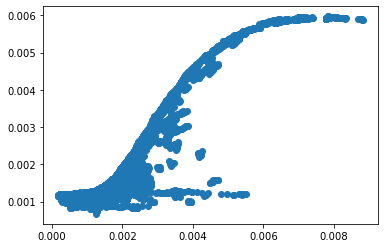

In [86]:
# GateNet cs

xx = []
yy = []

for i in range(10):
    xx += list(model(x_test[i]).detach().cpu().numpy()[:,0])
    yy += list(y_test[i].cpu().numpy()[:,0])
    
plt.scatter(yy, xx)
plt.show()
# print(np.mean((np.array(xx)-np.array(yy))**2))

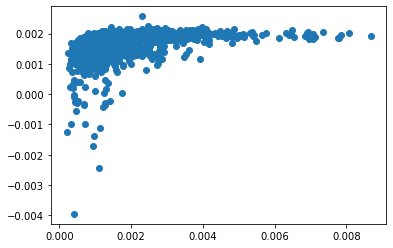

In [88]:
# linear cs

xx = []
yy = []
for i in range(1):
    xx += list(model(x_test[i]).detach().cpu().numpy()[:,0])
    yy += list(y_test[i].cpu().numpy()[:,0])
plt.scatter(yy, xx)
plt.show()

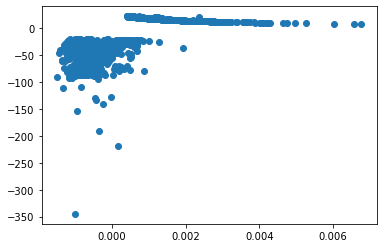

0.7001803088326078


In [66]:
# multilinear cs

xx = []
yy = []
for i in range(1):
    xx += list(model(x_test[i]).detach().cpu().numpy()[:,0])
    yy += list(y_test[i].cpu().numpy()[:,0])
plt.scatter(yy, xx)
plt.show()
print(np.corrcoef(xx,yy)[0,1])

#### 查看线性函数的参数

In [90]:
model.weight

Parameter containing:
tensor([[-3.0066e-02, -8.4163e-02,  6.1020e-03, -1.4581e-05]], device='cuda:0',
       requires_grad=True)

## 置换特征重要性
我们将使用置换特征重要性(Permutation Feature Importance)来研究不同特征对于模型预测价差的重要性. 我们将使用os数据进行测试,考虑到is和os的表现具有较高的一致性,这个选择不会造成麻烦.

In [118]:
# 首先计算原始模型的表现
corr = []
for i in range(len(x_test)):
    corr.append(np.corrcoef(model(x_test[i]).detach().cpu().numpy()[:,0], y_test[i].cpu().numpy()[:,0])[0,1])
print('model: {:.4f}'.format(np.mean(corr)))
nor = np.mean(corr)

# 对每个特征对换,计算表现以及下降的比例
for j in range(4):
    for i in range(len(x_test)):
        x_tmp = x_test[i]
        x_tmp[:,j] = torch.flip(x_tmp[:,j],dims=[0])
        corr.append(np.corrcoef(model(x_tmp).detach().cpu().numpy()[:,0], y_test[i].cpu().numpy()[:,0])[0,1])
        x_tmp[:,j] = torch.flip(x_tmp[:,j],dims=[0])
    print('{}: {:.4f}'.format(j, np.mean(corr)), (1-np.mean(corr)/nor)*100)


model: 0.9318
0: 0.9291 0.28758358157313646
1: 0.9301 0.18601228595827024
2: 0.9294 0.2573704977122171
3: 0.7273 21.951058199542484


## 构造额外特征然后存储到硬盘里，之后用控制台运行模型
2022-04-20
- 构造的特征除了几个价格之外，我们再加上几个文献中出现的，以及我们额外构造的一些

In [241]:
fmls = [
    'neg{tsmean{div{absv{tspct{close,1}},logv{volume}},20}}',  # 这个对低价股的反向比较明显
    'neg{tsmean{div{high,low},20}}',  # 20天平均振幅，对低价股和高价股是反向的
    'neg{tsmean{logv{cap},20}}',  # 对数市值越小相对价差越大
    'neg{tsmean{absv{minus{div{open,tsdelay{close,1}},1}},20}}',  # 隔夜收益率绝对值均值
    'neg{tsstd{tspct{close,1},20}}',  # 20天波动率
    'neg{div{tsmax{high,20},tsmin{low,20}}}',  # 20天振幅
]

fml =  fmls[0]

stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread', back=20)

mean corr: 0.3036, positive_corr_ratio: 0.9865, corr_IR: 3.4353


In [240]:
fml =  'tsmean{div{absv{minus{close,open}},minus{open,tsdelay{close,1}}},20}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread', back=20)

mean corr: -0.0430, positive_corr_ratio: 0.2780, corr_IR: -0.4713


In [254]:
fmls = [
    'tsmean{div{absv{tsdelta{close,1}},logv{volume}},20}',  # 这个对低价股的反向比较明显
    'tsmean{minus{high,low},20}',  # 20天平均振幅，对低价股和高价股是反向的
    'tsmean{logv{cap},20}',  # 对数市值越小相对价差越大
    'tsmean{absv{minus{open,tsdelay{close,1}}},20}',  # 隔夜收益率绝对值均值
    'tsstd{tsdelta{close,1},20}',  # 20天波动率
    'minus{tsmax{high,20},tsmin{low,20}}',  # 20天振幅
]

signal_tmp = np.zeros((243,2081,10), dtype=np.float32)
signal_tmp[:,:,6:] = signal_spread
for i in range(6):
    fml = fmls[i]
    stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='spread', back=20)
    signal_tmp[:,:,i] = signal
    

mean corr: 0.8436, positive_corr_ratio: 1.0000, corr_IR: 20.4639
mean corr: 0.8620, positive_corr_ratio: 1.0000, corr_IR: 32.3486
mean corr: 0.2175, positive_corr_ratio: 1.0000, corr_IR: 6.9403
mean corr: 0.7480, positive_corr_ratio: 1.0000, corr_IR: 9.3478
mean corr: 0.7810, positive_corr_ratio: 1.0000, corr_IR: 9.4873
mean corr: 0.7962, positive_corr_ratio: 1.0000, corr_IR: 14.8345


In [269]:
xx, yy = get_full_batch(signal_rela, target_rela, univ)

In [280]:
y.shape

torch.Size([424516, 1])

In [284]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

model = nn.Linear(4, 1).to(device)
loss_func = MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=0)

bs = 0
loss = 0

verbose=100
epochs=1000

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_func(model(x), y)
    loss.backward()
    optimizer.step()


    if (epoch+1) % verbose == 0:
        print('epoch {}'.format(epoch+1))
        print(float(loss))


epoch 100
0.00024123868206515908
epoch 200
3.0825456178718014e-06
epoch 300
5.088759849058988e-07
epoch 400
4.651628842111677e-07
epoch 500
4.649562299618992e-07
epoch 600
4.6495597416651435e-07
epoch 700
4.6495597416651435e-07
epoch 800
4.6495597416651435e-07
epoch 900
4.6495597416651435e-07
epoch 1000
4.6495597416651435e-07
